# Replication - Resource comparision (Runtime only)

Here we provide a notebook that showcases how to replicate the resource results. (This is not exact as hardware etc. will be differnt).
We also cannot provide the memory footprint as we cannot measure it for the R scripts. 
For simplicity we also do not provide the Probcox - Hard drive version here.

The notebook indicates how to replicate the results in:
- /out/resources/*

The main script can be found at: 
- /scripts/resources/*


In [1]:
# google colab specific - installing probcox
!pip3 install probcox
!pip3 install lifelines

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 607 kB 5.6 MB/s 
  Created wheel for probcox: filename=probcox-0.0.5-py3-none-any.whl size=5224 sha256=917318a2f558aa07b77b65489c5781c1baf2eaf72c87afdaea7536152ae63892
  Stored in directory: /root/.cache/pip/wheels/7b/6c/69/1adac1abb2e1e8c9d58200fa7a181920d2f7c90809c837d47a
Successfully built probcox
     |████████████████████████████████| 348 kB 4.2 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=0da2100e2f5bcc90a28bfe75ce418315dd7430cbe494eee1b5d1363ceb755035
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R 
install.packages('survival')
install.packages('glmnet')

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/survival_3.2-13.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 6545339 bytes (6.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[w

In [4]:
%%R 
library(survival)
library(glmnet)

R[write to console]: Loading required package: Matrix

R[write to console]: Loaded glmnet 4.1-3



In [5]:
# Modules
# =======================================================================================================================
import os
import sys
import shutil
import subprocess
import tqdm

import numpy as np
import pandas as pd
from lifelines import CoxTimeVaryingFitter

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro.infer import SVI, Trace_ELBO

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import probcox as pcox

dtype = torch.FloatTensor

np.random.seed(9044)
torch.manual_seed(8734)




In [6]:
# Plot Settings
# =======================================================================================================================

plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


In [7]:
# ProbCox settings
# =======================================================================================================================
batchsize = 256

def predictor(data):
    theta =  pyro.sample("theta", dist.StudentT(1, loc=0, scale=0.001).expand([data[1].shape[1], 1])).type(dtype)
    pred = torch.mm(data[1], theta)
    return(pred)

In [8]:
# Simulation - 10 Significant covariates
# =======================================================================================================================
def simulate(I, P):
  P_binary = int(P/2)
  P_continuous = int(P/2)
  theta = np.random.normal(0, 0.5, (10, 1))
  theta = np.concatenate((theta[:5], np.zeros((int(P/2-5), 1)), theta[5:], np.zeros((int(P/2-5), 1))))
  scale = 2  # Scaling factor for Baseline Hazard

  # Class for simulation
  TVC = pcox.TVC(theta=theta, P_binary=P_binary, P_continuous=P_continuous, dtype=dtype)

  # Sample baseline hazard - scale is set to define censorship/events
  TVC.make_lambda0(scale=scale)

  # Sample Data 
  surv = torch.zeros((0, 3))
  X = torch.zeros((0, P))
  for __ in tqdm.tqdm(range(I)):
      a, b = TVC.sample()
      surv = torch.cat((surv, a))
      X = torch.cat((X, b))
  return(surv, X, theta)

In [9]:
# ProbCox
# =======================================================================================================================
def run_probcox(surv, X, sampling_proportion, predictor=predictor):
  eta=1
  run = True
  while run:
      run = False
      pyro.clear_param_store()
      m = pcox.PCox(sampling_proportion=sampling_proportion, predictor=predictor)
      m.initialize(eta=eta, rank=25)
      loss=[0]
      for ii in tqdm.tqdm(range((25000))):
          # random sub-sampling
          idx = np.random.choice(range(surv.shape[0]), batchsize, replace=False)
          data=[surv[idx], X[idx]]
          loss.append(m.infer(data=data))
          # divergence check
          if loss[-1] != loss[-1]:
              eta = eta * 0.1
              run=True
              break   
  g = m.return_guide()
  out = g.quantiles([0.025, 0.5, 0.975])
  return(out)    

In [10]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=16000, P=3200)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]


100%|██████████| 16000/16000 [1:12:46<00:00,  3.66it/s]


119071


In [11]:

%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)


100%|██████████| 25000/25000 [21:01<00:00, 19.83it/s]


CPU times: user 12min 17s, sys: 8min 45s, total: 21min 3s
Wall time: 21min 3s


In [12]:
'''
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

# More then an hour to run
'''

SyntaxError: ignored

In [ ]:
'''
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:3203]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

# crashes for memory
'''

In [ ]:
'''
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)
'''

In [13]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=8000, P=1600)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 8000/8000 [10:06<00:00, 13.19it/s]


58842


In [14]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [09:50<00:00, 42.32it/s]

CPU times: user 6min 46s, sys: 3min 6s, total: 9min 52s
Wall time: 9min 51s


In [15]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 1h 41min 57s, sys: 16.6 s, total: 1h 42min 14s
Wall time: 1h 41min 31s


In [16]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:1603]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 12min 42s, sys: 56.3 s, total: 13min 38s
Wall time: 12min 4s


In [17]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


CPU times: user 3h 28min 11s, sys: 22min 38s, total: 3h 50min 50s
Wall time: 2h 46s


In [18]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=4000, P=800)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 4000/4000 [01:39<00:00, 40.16it/s]


29628


In [19]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [04:04<00:00, 102.16it/s]

CPU times: user 4min 2s, sys: 3.6 s, total: 4min 6s
Wall time: 4min 7s


In [20]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 5min 5s, sys: 3.2 s, total: 5min 8s
Wall time: 5min 6s


In [21]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:803]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 3min 47s, sys: 44.1 s, total: 4min 32s
Wall time: 3min 34s


In [22]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


CPU times: user 15min 39s, sys: 2min 58s, total: 18min 37s
Wall time: 9min 34s


In [23]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=2000, P=400)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 2000/2000 [00:18<00:00, 108.43it/s]

14937


In [24]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [02:42<00:00, 153.84it/s]

CPU times: user 2min 41s, sys: 2.14 s, total: 2min 43s
Wall time: 2min 43s


In [25]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 49 s, sys: 463 ms, total: 49.4 s
Wall time: 49.1 s


In [26]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:403]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 2min 1s, sys: 1min 3s, total: 3min 4s
Wall time: 1min 50s


In [27]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


CPU times: user 1min 17s, sys: 25.9 s, total: 1min 43s
Wall time: 53.7 s


In [28]:
# Simulate Data
# =======================================================================================================================
pyro.clear_param_store()
np.random.seed(9044)
torch.manual_seed(8734)
surv, X, theta = simulate(I=1000, P=200)
print(surv.shape[0])
# sampling proportion
total_obs = surv.shape[0]
total_events = torch.sum(surv[:, -1] == 1).numpy().tolist()
sampling_proportion=[total_obs, batchsize, total_events, None]
# Make High-dimensional Data
# R dataset 
rd = pd.DataFrame(np.concatenate((surv.detach().numpy(), X.detach().numpy()), axis=1))
rd.columns = ['V' + str(ii) for ii in range(1, rd.shape[1]+1)]

100%|██████████| 1000/1000 [00:08<00:00, 111.88it/s]

7248


In [29]:
%%time
out = run_probcox(surv=surv, X=X, sampling_proportion=sampling_proportion)

100%|██████████| 25000/25000 [02:07<00:00, 195.54it/s]

CPU times: user 2min 8s, sys: 1.4 s, total: 2min 9s
Wall time: 2min 9s


In [30]:
%%time
%%R -i rd -o r_coef
set.seed(7)
Surv(rd$V1, rd$V2, rd$V3)
m = coxph(Surv(V1, V2, V3)~., data=rd)
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 8.76 s, sys: 145 ms, total: 8.9 s
Wall time: 8.82 s


In [31]:
%%time
%%R -i rd -o r_coef
set.seed(13)
yss = Surv(rd$V1, rd$V2, rd$V3)
m <- glmnet(as.matrix(rd[, 4:203]), yss, family ="cox")
r_coef <- as.matrix(unname(coef(m)))

CPU times: user 44.7 s, sys: 29.2 s, total: 1min 13s
Wall time: 40.4 s


In [32]:
%%time
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(rd, event_col="V3", start_col="V1", stop_col="V2", show_progress=False)


CPU times: user 6.77 s, sys: 3.38 s, total: 10.2 s
Wall time: 5.27 s


## Report results:

In [2]:
I =  ['I:1000, P:200', 'I:2000, P:400', 'I:4000, P:800', 'I:8000, P:1600', 'I:16000, P:3200']
probcox = [129, 163, 247, 591, 1263]
rsurvival = [9, 49, 306, 6091]
rglmnet = [40, 110, 214, 724]
plifelines = [5, 53, 574, 7246]

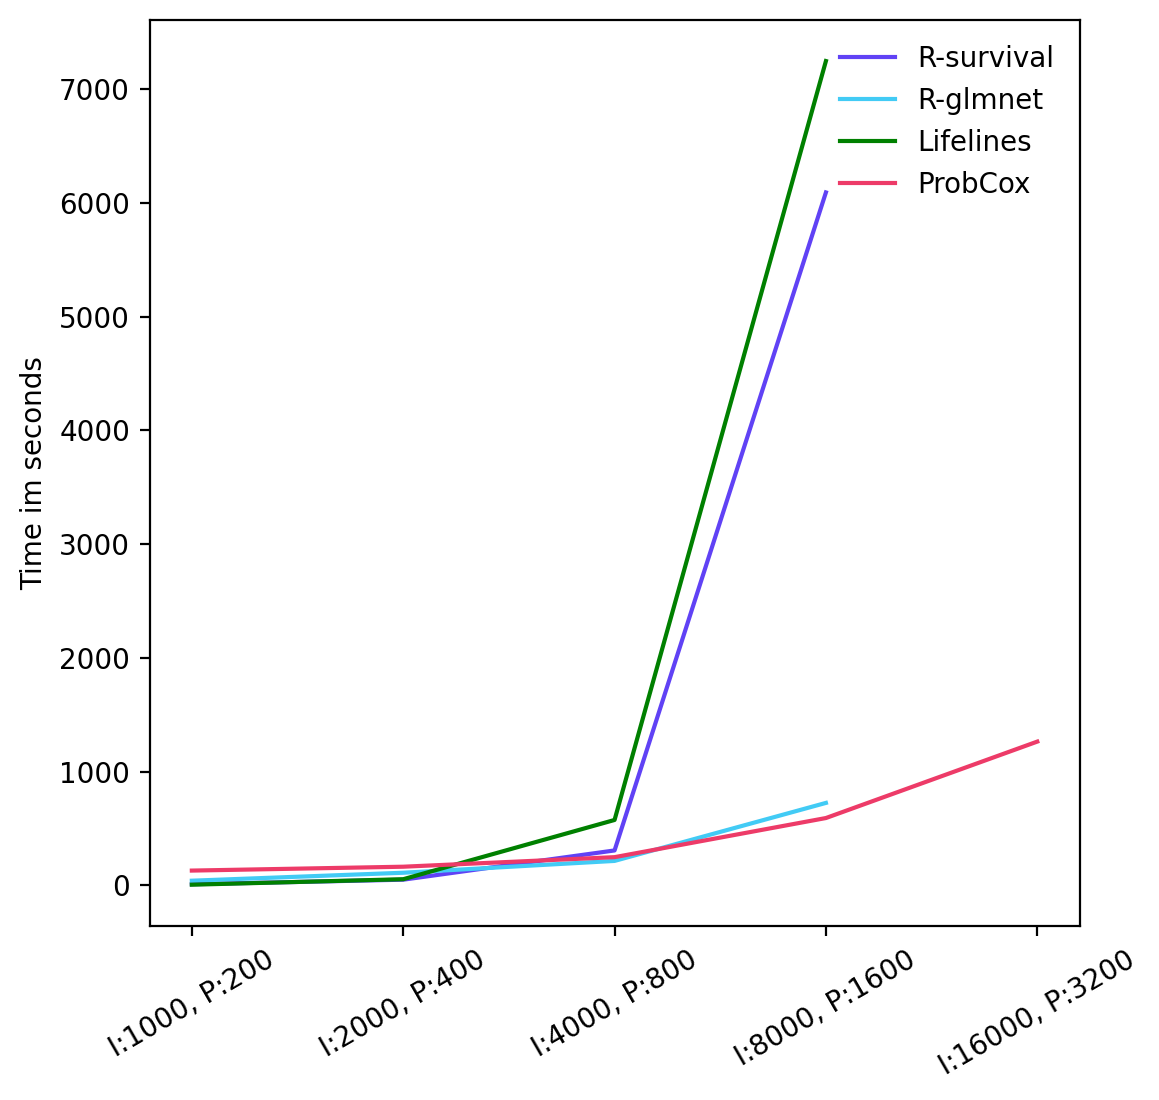

In [10]:
plt.figure(figsize=(6, 6), dpi=200)
plt.plot(np.arange(4), rsurvival, label='R-survival', color='#6042f5')
plt.plot(np.arange(4), rglmnet, label='R-glmnet', color='#42cbf5')
plt.plot(np.arange(4), plifelines, label='Lifelines', color='green')
plt.plot(np.arange(5), probcox, label='ProbCox', color='#ed3b68')
plt.xticks(np.arange(5), labels=I, rotation = 30)
plt.ylabel('Time im seconds')
plt.legend(frameon=False)
plt.show()
plt.close()

# Compute Specifications

In [ ]:
from psutil import *

In [ ]:
print(cpu_count())
print(cpu_stats())

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!df -h

In [ ]:
virtual_memory()